# Lab Exercise #3 


### NOTES
- Main Problem = OVERFITTING
- Data Augmentation - (Brightness, Contrast, Rotate)
- Conv2D Filters - 64, 128, 256, 512
- ImgSize = 128x128
+ ReduceLROnPlateau
+ EarlyStopping
+ Flatten
+ Dense
+ Dropout
- Evaluation = TrainAcc(0.9059), ValAcc(0.5949)

Attempt 1 - Modelling
- Medyo ginaya ko yung data loading ni amiel
- accuracy: 0.7240 - loss: 0.5475 - val_accuracy: 0.5231 - val_loss: 1.0059

Attempt 2 - Modelling + 1 CONVLAYER


In [931]:
#%pip install tensorflow
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install pydot
#%pip install scipy

## Dataset Validation

In [932]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

## Hyperparameters


In [933]:
# For easy modification
height = 128
width = 128
image_size = (height, width)
batch_size = 32
epochs = 50


## Loading the Dataset

In [934]:
import tensorflow as tf

# Load Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
    #shuffle=True,
)

# Load Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
    #shuffle=True,
)

Found 978 files belonging to 3 classes.
Using 783 files for training.
Found 978 files belonging to 3 classes.
Using 195 files for validation.


## Data Profiling and Visualization

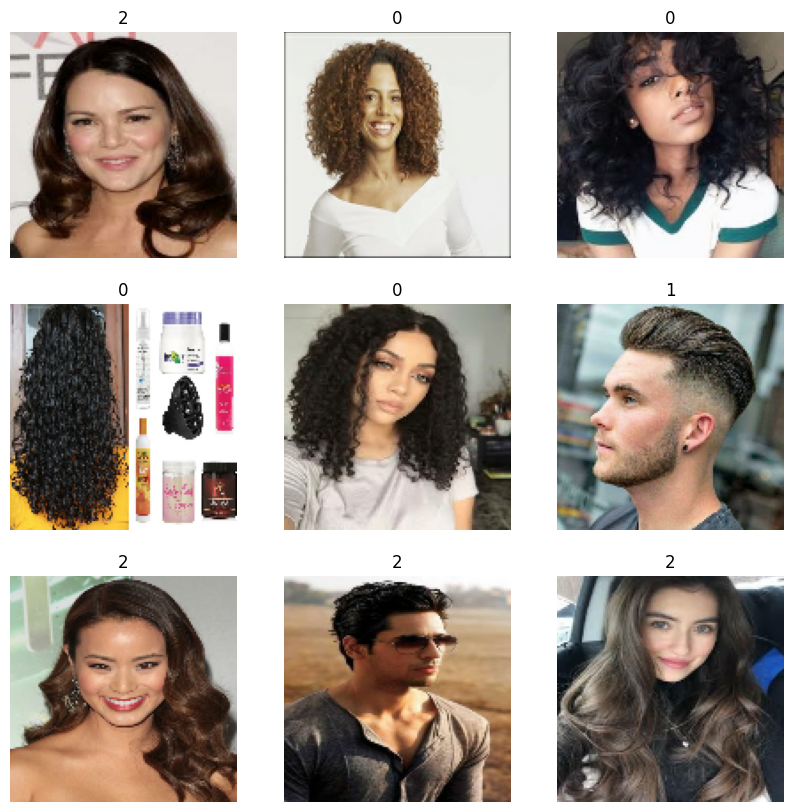

In [935]:
import matplotlib.pyplot as plt
import numpy as np

# Shuffle the dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for images, labels in train_ds_shuffled.take(1):  # Take a batch of images from the shuffled dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

## Data Augmentation

In [936]:
def augment_data(image, label):
    #image = tf.image.random_brightness(image, max_delta=2)  # Adjust brightness randomly
    #image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast randomly
    #image = random_rotate_image(image)
    #image = tf.image.random_crop(image, size=[224, 224, 3])  # Randomly crop the image
    #image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
    #image = tf.image.random_flip_up_down(image)  # Randomly flip images vertically
    #image = tf.image.random_zoom(image, (0.8, 1.2))  # Randomly zoom into or out of the image
    #image = tf.image.random_shear(image, 0.2)  # Randomly apply shearing transformation
    #image = tf.image.random_translation(image, 0.2, 0.2)  # Randomly translate the image
    #image = tf.clip_by_value(image, 0, 1)  # Clip pixel values to [0, 1] range
    return image, label


def random_rotate_image(image):
    random_angle = tf.random.uniform([], minval=0, maxval=12, dtype=tf.int32) * 30  # Generate a random angle between 0 and 330 degrees
    rotated_image = tf.image.rot90(image, k=random_angle // 90)   # Rotate the image by the random angle
    return rotated_image

augmented_train_ds = train_ds.map(augment_data)


from keras import layers
resize_and_rescale = keras.Sequential([
    layers.Resizing(height=height, width=width),
    layers.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(factor=0.2),
])

---

import tensorflow as tf

def augment_data(image, label):
    # image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
    # image = tf.image.random_flip_up_down(image)  # Randomly flip images vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness randomly
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast randomly
    image = random_rotate_image(image)
    return image, label


def random_rotate_image(image):
    random_angle = tf.random.uniform([], minval=0, maxval=12, dtype=tf.int32) * 30  # Generate a random angle between 0 and 330 degrees
    rotated_image = tf.image.rot90(image, k=random_angle // 90)   # Rotate the image by the random angle
    return rotated_image

augmented_train_ds = train_ds.map(augment_data)

-----------------
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images, _ = augment_data(images[i], None)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images).astype("uint8"))
        plt.axis("off")
plt.show()
--------------------------
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
plt.show()

### Data Augmentation Visualization

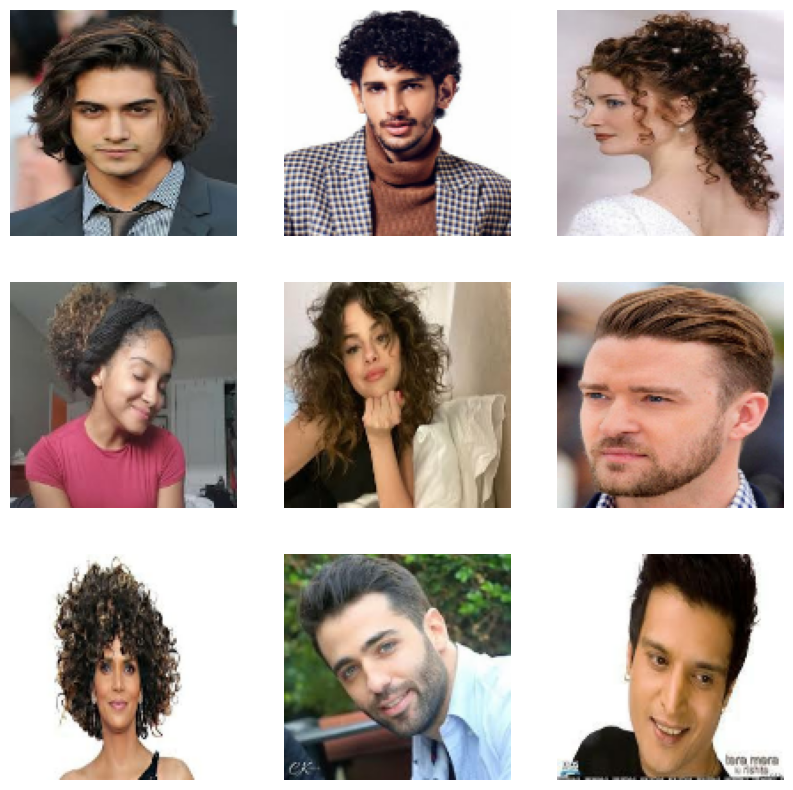

In [937]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images, _ = augment_data(images[i], None)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images).astype("uint8"))
        plt.axis("off")
plt.show()

## Model Architecture

In [938]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler


# Define your model architecture
model = keras.Sequential()

model.add(keras.Input(shape=image_size + (3,)))
model.add(layers.Rescaling(1.0 / 255))

#model.add(layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu'))
#model.add(layers.MaxPooling2D(pool_size=2, strides=2))
#model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu',  dilation_rate=1))
model.add(layers.MaxPooling2D(pool_size=2, strides=2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu',  dilation_rate=1))
model.add(layers.MaxPooling2D(pool_size=2, strides=2))
#model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu',  dilation_rate=1))
#model.add(layers.MaxPooling2D(pool_size=2, strides=2))
#model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu',  dilation_rate=1))
#model.add(layers.MaxPooling2D(pool_size=2, strides=2))
#model.add(layers.BatchNormalization())


model.add(layers.GlobalMaxPooling2D())
model.add(layers.Flatten())

model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


#class DropConnect(layers.Layer):
    #def __init__(self, rate, **kwargs):
        #super(DropConnect, self).__init__(**kwargs)
        #self.rate = rate

    #def call(self, inputs, training=None):
        #if training:
            #return tf.nn.dropout(inputs, rate=self.rate)
        #return inputs

# Adding normalization layer
#model.add(layers.LayerNormalization())

# Adding DropConnect layer
#model.add(DropConnect(rate=0.5))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduling
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

def learning_rate_schedule(epoch, initial_lr=1e-3, drop=0.1, epochs_drop=12):
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

# Train the model with augmented data
#history = model.fit(augmented_train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)])

history = model.fit(augmented_train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_87 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_299 (Conv2D)             │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_277               │ (None, 63, 63, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_266         │ (None, 63, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_300 (Conv2D)             │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_278               │ (None, 30, 30, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_301 (Conv2D)             │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_302 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_62         │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_80 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,955 (413.89 KB)

 Trainable params: 105,923 (413.76 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.3809 - loss: 1.1457 - val_accuracy: 0.4256 - val_loss: 1.0975 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.3997 - loss: 1.0902 - val_accuracy: 0.3692 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.3973 - loss: 1.0766 - val_accuracy: 0.3641 - val_loss: 1.0932 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.4640 - loss: 1.0415 - val_accuracy: 0.3692 - val_loss: 1.0904 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.4954 - loss: 1.0075 - val_accuracy: 0.4154 - val_loss: 1.0857 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.4634 - loss: 1.0147 - val_accuracy: 0.4154 - val_loss: 1.0818 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.5597 - loss: 0.9578 - 

## Model Evaluation

In [939]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
This image is 0.89 percent curly hair, 0.08 percent straight hair, and 0.03 percent wavy hair.


### Random Picture Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
For the randomly chosen image (Long-Let-Loose.jpg) from folder: hair_types/Straight_Hair/, the predicted percentages are: Curly Hair: 73.59%, Straight Hair: 22.51%, Wavy Hair: 3.90%.


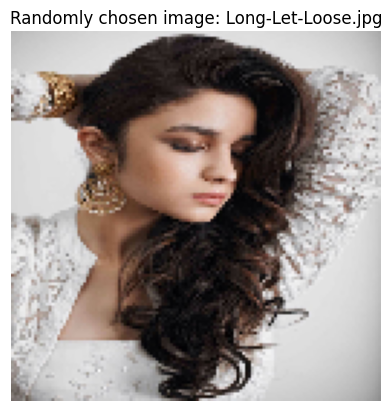

In [940]:
import os
import random
import matplotlib.pyplot as plt

# Set the directory containing your dataset
folder_number = random.randint(1, 3)  # Generate a random number between 1-3
if folder_number == 1:
    dataset_dir = "hair_types/Curly_Hair/"
elif folder_number == 2:
    dataset_dir = "hair_types/Straight_Hair/"
else:
    dataset_dir = "hair_types/Wavy_Hair/"

# Get a list of all files in the dataset directory
file_list = os.listdir(dataset_dir)

# Choose a random file from the list
random_file = random.choice(file_list)

# Construct the path to the randomly chosen image
image_path = os.path.join(dataset_dir, random_file)

# Load the image
img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)

# Print the results along with the folder where the image came from
print(
    f"For the randomly chosen image ({random_file}) from folder: {dataset_dir}, the predicted percentages are: Curly Hair: {predictions[0][0] * 100:.2f}%, Straight Hair: {predictions[0][1] * 100:.2f}%, Wavy Hair: {predictions[0][2] * 100:.2f}%."
)

# Display the image
plt.imshow(img)
plt.title("Randomly chosen image: " + random_file)
plt.axis("off")
plt.show()


### Overfit Plot Table

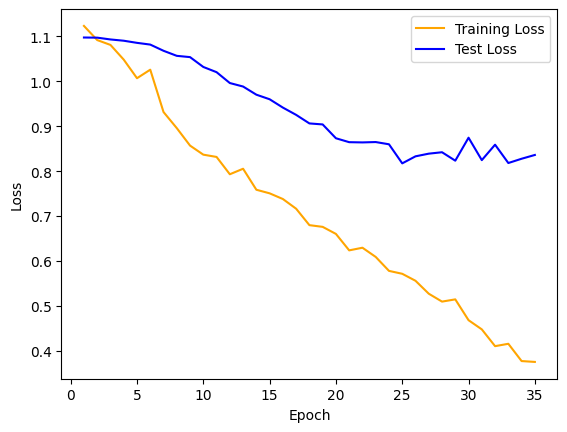

In [941]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, color="orange")
plt.plot(epoch_count, val_loss, color="blue")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

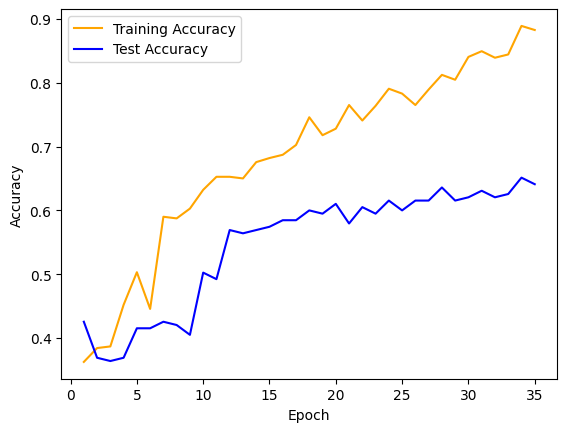

In [942]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_acc, color="orange")
plt.plot(epoch_count, val_acc, color="blue")
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();
